## demo decam

This walkthrough uses the Burke et al. 2019 dataset, but superceeds the old Matterport Mask R-CNN implementation.

#### A few notes:

The data can be obtained following the links in the [old repository](https://github.com/burke86/astro_rcnn). The dataset directories should be re-named "test", "train", and "val".

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data import build_detection_train_loader
from detectron2.data import build_detection_test_loader

from detectron2.engine import DefaultTrainer
from detectron2.engine import SimpleTrainer
from detectron2.engine import HookBase
from typing import Dict, List, Optional
import detectron2.solver as solver
import detectron2.modeling as modeler
import detectron2.data as data
import detectron2.data.transforms as T
import detectron2.checkpoint as checkpointer
from detectron2.data import detection_utils as utils
import weakref
import copy
import torch
import time

import imgaug.augmenters as iaa

from astrodet import astrodet as toolkit
from PIL import Image, ImageEnhance
from astropy.visualization import make_lupton_rgb


In [2]:
# Print some versions so we know what works
print(torch.__version__)
print(detectron2.__version__)

1.10.1
0.6


In [3]:
# Prettify the plotting
from astrodet.astrodet import set_mpl_style
set_mpl_style()

In [4]:
#Todo: change the dirpath here
dirpath = '/home/shared/hsc/decam/decam_data/' # Path to dataset
output_dir = '/home/shared/hsc/decam/models/'

dataset_names = ['train', 'test', 'val'] 

### Register Astro R-CNN dataset

In [5]:
from detectron2.structures import BoxMode
from astropy.io import fits
import glob

def get_astro_dicts(img_dir):
        
    # It's weird to call this img_dir
    set_dirs = sorted(glob.glob('%s/set_*' % img_dir))
    
    dataset_dicts = []
    
    # Loop through each set
    for idx, set_dir in enumerate(set_dirs):
        record = {}
        
        mask_dir = os.path.join(img_dir, set_dir, "masks.fits")
        filename = os.path.join(img_dir, set_dir, "img")
        
        # Open each FITS image
        with fits.open(mask_dir, memmap=False, lazy_load_hdus=False) as hdul:
            sources = len(hdul)
            height, width = hdul[0].data.shape
            data = [hdu.data/np.max(hdu.data) for hdu in hdul]
            category_ids = [hdu.header["CLASS_ID"] for hdu in hdul]
            
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        objs = []
        
        # Mask value thresholds per category_id
        thresh = [0.005 if i == 1 else 0.08 for i in category_ids]
        
        # Generate segmentation masks
        for i in range(sources):
            image = data[i]
            mask = np.zeros([height, width], dtype=np.uint8)
            # Create mask from threshold
            mask[:,:][image > thresh[i]] = 1
            # Smooth mask
            mask[:,:] = cv2.GaussianBlur(mask[:,:], (9,9), 2)
            
            # https://github.com/facebookresearch/Detectron/issues/100
            contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE,
                                                        cv2.CHAIN_APPROX_SIMPLE)
            segmentation = []
            for contour in contours:
                x,y,w,h = cv2.boundingRect(contour)
                contour = contour.flatten().tolist()
                # segmentation.append(contour)
                if len(contour) > 4:
                    segmentation.append(contour)
            # No valid countors
            if len(segmentation) == 0:
                continue
            
            # Add to dict
            obj = {
                "bbox": [x, y, w, h],
                "area": w*h,
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": segmentation,
                "category_id": category_ids[i] - 1,
            }
            objs.append(obj)
            
        record["annotations"] = objs
        dataset_dicts.append(record)
         
    return dataset_dicts


#for i, d in enumerate(dataset_names):
#    filenames_dir = os.path.join(dirpath,d)
#    DatasetCatalog.register("astro_" + d, lambda: get_astro_dicts(filenames_dir))
#    MetadataCatalog.get("astro_" + d).set(thing_classes=["star", "galaxy"], things_colors = ['blue', 'gray'])
#astro_metadata = MetadataCatalog.get("astro_train")

In [6]:

#code snippet for unregistering if you want to change something

if "astro_train" in DatasetCatalog.list():
    print('removing astro_train')
    DatasetCatalog.remove("astro_train")
    
    
if "astro_test" in DatasetCatalog.list():
    print('removing astro_test')
    DatasetCatalog.remove("astro_test")
    
if "astro_val" in DatasetCatalog.list():
    print('removing astro_val')
    DatasetCatalog.remove("astro_val")



In [7]:
def get_data_from_json(file):
    # Opening JSON file
    with open(file, 'r') as f:
        data = json.load(f)
    return data


for i, d in enumerate(dataset_names):
    filenames_dir = os.path.join(dirpath,d)
    DatasetCatalog.register("astro_" + d, lambda: get_data_from_json(filenames_dir+'.json'))
    MetadataCatalog.get("astro_" + d).set(thing_classes=["star", "galaxy"], things_colors = ['blue', 'gray'])
astro_metadata = MetadataCatalog.get("astro_train")

In [1]:
import detectron2
detectron2.__path__

['/home/g4merz/.local/lib/python3.9/site-packages/detectron2']

### Custom image reader

In [8]:
def read_image(filename, normalize='lupton', stretch=5, Q=10, m=0, ceil_percentile=99.995, dtype=np.uint8, A=1e4):
    # Read image
    g = fits.getdata(os.path.join(filename+'_g.fits'), memmap=False)
    r = fits.getdata(os.path.join(filename+'_r.fits'), memmap=False)
    z = fits.getdata(os.path.join(filename+'_z.fits'), memmap=False)
    
    # Contrast scaling / normalization
    I = (z + r + g)/3.0
    
    length, width = g.shape
    image = np.empty([length, width, 3], dtype=dtype)
    
    # Options for contrast scaling
    if normalize.lower() == 'lupton' or normalize.lower() == 'luptonhc':
        z = z*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        r = r*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        g = g*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        
    elif normalize.lower() == 'zscore':
        
        Isigma = I*np.mean([np.nanstd(g), np.nanstd(r), np.nanstd(z)])
        z = (z - np.nanmean(z) - m)/Isigma
        r = (r - np.nanmean(r) - m)/Isigma
        g = (g - np.nanmean(g) - m)/Isigma
        
        #zsigma = np.nanstd(z)
        #rsigma = np.nanstd(r)
        #gsigma = np.nanstd(g)
        
        #z = A*(z - np.nanmean(z) - m)/zsigma
        #r = A*(r - np.nanmean(r) - m)/rsigma
        #g = A*(g - np.nanmean(g) - m)/gsigma
        
        
    elif normalize.lower() == 'linear':
        z = (z - m)/I
        r = (r - m)/I
        g = (g - m)/I
        
    
    
    else:
        print('Normalize keyword not recognized.')

    max_RGB = np.nanpercentile([z, r, g], ceil_percentile)
    #max_RGB = np.nanpercentile([z, r, g], ceil_percentile)

    # avoid saturation
    r = r/max_RGB; g = g/max_RGB; z = z/max_RGB

    # Rescale to 0-255 for dtype=np.uint8
    max_dtype = np.iinfo(dtype).max
    r = r*max_dtype
    g = g*max_dtype
    z = z*max_dtype

    # 0-255 RGB image
    image[:,:,0] = z # R
    image[:,:,1] = r # G
    image[:,:,2] = g # B
    
    if normalize.lower() == 'luptonhc':
        factor = 2 #gives original image
        cenhancer = ImageEnhance.Contrast(Image.fromarray(image))
        im_output = cenhancer.enhance(factor)
        benhancer = ImageEnhance.Brightness(im_output)
        image = benhancer.enhance(factor)
    
    return np.asarray(image)

In [9]:
def rescale_image(filename, normalize='lupton', stretch=5, Q=10, m=0, ceil_percentile=99.995, dtype=np.uint8, A=1e4):
    # Read image
    g = fits.getdata(os.path.join(filename+'_g.fits'), memmap=False)
    r = fits.getdata(os.path.join(filename+'_r.fits'), memmap=False)
    z = fits.getdata(os.path.join(filename+'_z.fits'), memmap=False)
    
    # Contrast scaling / normalization
    I = (z + r + g)/3.0
    
    length, width = g.shape
    image = np.empty([length, width, 3], dtype=dtype)
    
    # Options for contrast scaling
    if normalize.lower() == 'lupton':
        z = z*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        r = r*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        g = g*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        
        
        #max_RGB = np.nanpercentile([z, r, g], ceil_percentile) * 2
        max_RGB = np.nanpercentile([z, r, g], ceil_percentile)

        #max_RGB = np.max([g,r,z])


        # avoid saturation
        r = r/max_RGB; g = g/max_RGB; z = z/max_RGB

        # Rescale to 0-255 for dtype=np.uint8
        max_dtype = np.iinfo(dtype).max
        r = r*max_dtype
        g = g*max_dtype
        z = z*max_dtype
        
        
    elif normalize.lower() == 'zscore':
        
        
        #Isigma = I*np.mean([np.nanstd(g), np.nanstd(r), np.nanstd(z)])
        #z = (z - np.nanmean(z) - m)/Isigma
        #r = (r - np.nanmean(r) - m)/Isigma
        #g = (g - np.nanmean(g) - m)/Isigma
        
        zsigma = np.nanstd(z)
        rsigma = np.nanstd(r)
        gsigma = np.nanstd(g)
        
        z = A*(z - np.nanmean(z) - m)/zsigma
        r = A*(r - np.nanmean(r) - m)/rsigma
        g = A*(g - np.nanmean(g) - m)/gsigma
        
        #max_RGB = np.nanpercentile([z, r, g], ceil_percentile)

        # avoid saturation
        #r = r/max_RGB; g = g/max_RGB; z = z/max_RGB

        # Rescale to 0-255 for dtype=np.uint8
        #max_dtype = np.iinfo(dtype).max
        #r = r*max_dtype
        #g = g*max_dtype
        #z = z*max_dtype
        
        
    elif normalize.lower() == 'linear':
        z = (z - m)/I
        r = (r - m)/I
        g = (g - m)/I
    else:
        print('Normalize keyword not recognized.')



    # 0-255 RGB image
    image[:,:,0] = z # red
    image[:,:,1] = r # green
    image[:,:,2] = g # blue

    return image

In [10]:
# Dataset loading can take a while

In [11]:
dataset_dicts = {}
#for i, d in enumerate(dataset_names):
for i, d in enumerate(dataset_names):
    print(f'Loading {d}')
    filenames_dir = os.path.join(dirpath,d)
    dataset_dicts[d] = get_data_from_json(filenames_dir+'.json')

Loading train
Loading test
Loading val


### Visualize ground truth examples

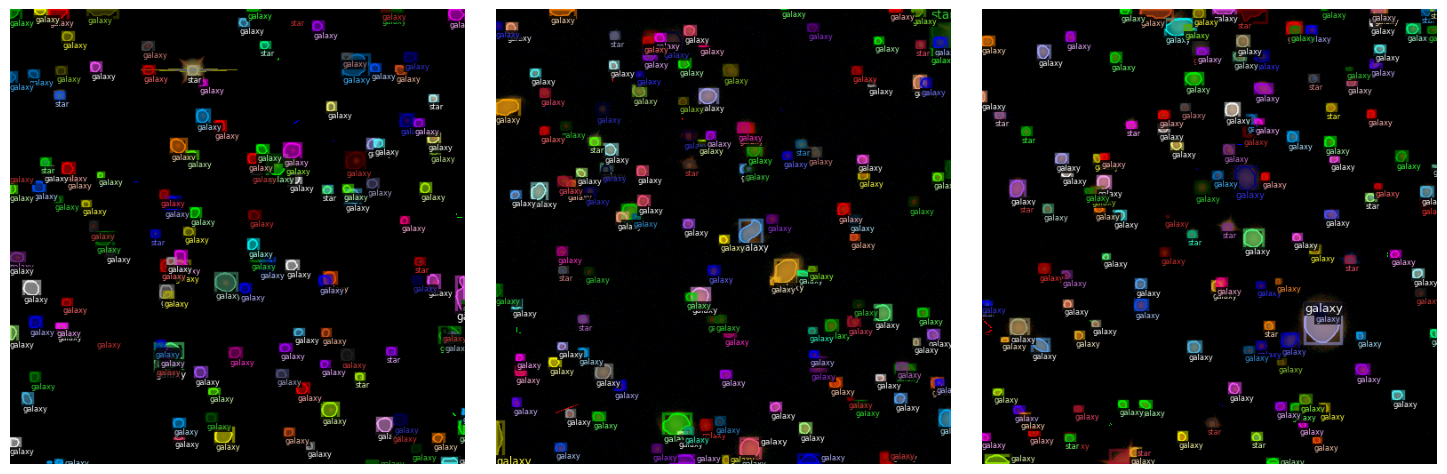

In [12]:
nsample = 3 # Number of example images to plot
fig, axs = plt.subplots(1, nsample, figsize=(5*nsample, 5))

for i, d in enumerate(random.sample(dataset_dicts['test'], nsample)):
    # Use the Lupton scaling for better visualization
    img = read_image(d["file_name"], normalize="zscore", stretch=5, Q=10, ceil_percentile=99.995,dtype=np.uint8)

    visualizer = Visualizer(img, metadata=astro_metadata)
    # Plot the figures
    out = visualizer.draw_dataset_dict(d)
    axs[i].imshow(out.get_image())
    axs[i].axis('off')
    fig.tight_layout()
    fig.show()


In [97]:
print(c[0])

luptonHC


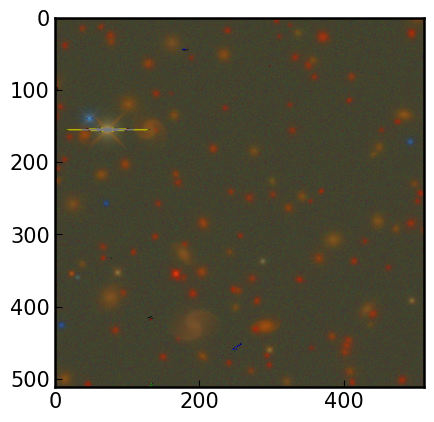

In [110]:
d=random.sample(dataset_dicts['test'], 1)[0]
#c = np.random.choice(scalings,1)[0]

#img = rescale_image(d["file_name"], normalize="lupton", stretch=5, Q=10, ceil_percentile=99.99,dtype=np.int16)
img = read_image(d["file_name"], normalize='lupton', stretch=5, Q=10, ceil_percentile=99.99,dtype=np.uint8)

plt.imshow(img)

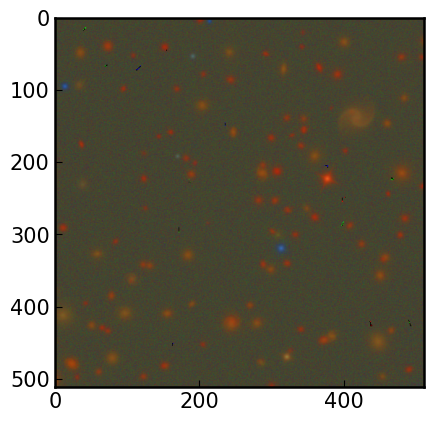

In [101]:
d=random.sample(dataset_dicts['test'], 1)[0]
img = read_image(d["file_name"], normalize="lupton", stretch=5, Q=10, ceil_percentile=99.99,dtype=np.int16)

plt.imshow(img)

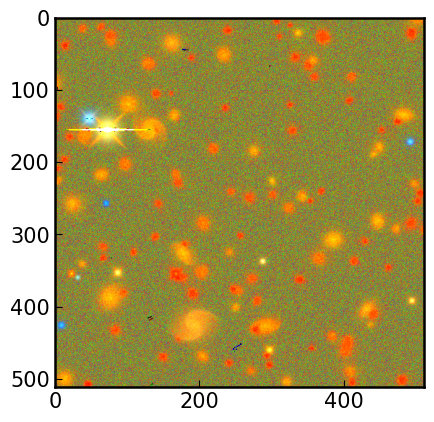

In [111]:
factor = 2 #gives original image

cenhancer = ImageEnhance.Contrast(Image.fromarray(img))

im_output = cenhancer.enhance(factor)
benhancer = ImageEnhance.Brightness(im_output)
im_output = benhancer.enhance(factor)
plt.imshow(im_output)

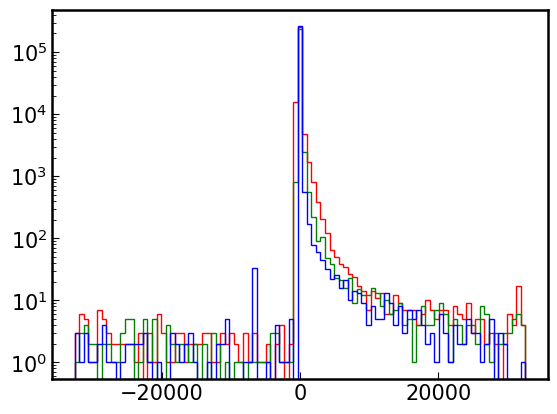

In [60]:
bins = np.linspace(-32566,32566,100)

plt.hist(img[:,:,0].flatten(),histtype="step",bins=bins,log=True,color="r");
plt.hist(img[:,:,1].flatten(),histtype="step",bins=bins,log=True,color="g");
plt.hist(img[:,:,2].flatten(),histtype="step",bins=bins,log=True,color="b");

In [ ]:
means = np.zeros(3)
stds = np.zeros(3)

m0=m1=m2=0
s0=s1=s2=0

for d in dataset_dicts['train']:
    img = rescale_image(d["file_name"], normalize="zscore", stretch=5, Q=10, ceil_percentile=99.995,dtype=np.int16)
    m0+=img[:,:,0].mean()
    m1+=img[:,:,1].mean()
    m2+=img[:,:,2].mean()
    
    s0+=img[:,:,0].std()
    s1+=img[:,:,1].std()
    s2+=img[:,:,2].std()
    
means[0] = m0
means[1] = m1
means[2] = m2

stds[0] = s0
stds[1] = s1
stds[2] = s2
tl=len(dataset_dicts['train'])
print(means/tl)
print(stds/tl)

In [32]:
d=random.sample(dataset_dicts['test'], 1)[0]
img = read_image(d["file_name"], normalize="zscore", stretch=5, Q=10, ceil_percentile=99.9,dtype=np.int16)
img2 = read_image(d["file_name"], normalize="lupton", stretch=5, Q=10, ceil_percentile=99.95, dtype=np.uint8,m=40)
#g = fits.getdata(os.path.join(d["file_name"]+'_g.fits'), memmap=False)
#r = fits.getdata(os.path.join(d["file_name"]+'_r.fits'), memmap=False)
#z = fits.getdata(os.path.join(d["file_name"]+'_z.fits'), memmap=False)
#print(img.mean(),img.max())
#print(img2.mean(),img2.max())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


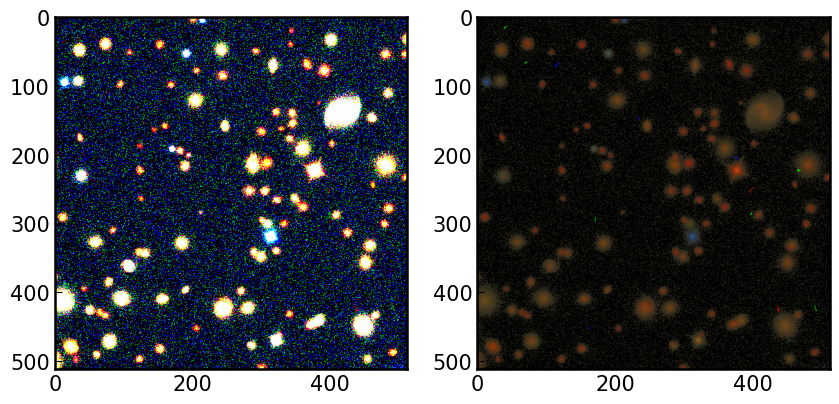

In [33]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(img)
ax[1].imshow(img2)

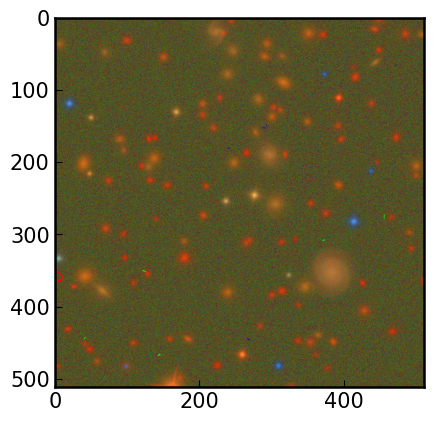

In [385]:
lup = make_lupton_rgb(z,r,g,stretch=10,Q=30,minimum=20)
plt.imshow(lup)

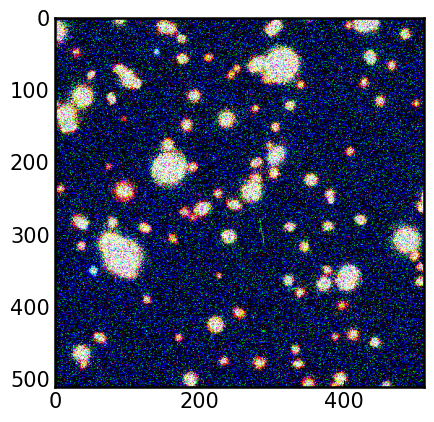

In [79]:
factor = 2 #gives original image

cenhancer = ImageEnhance.Contrast(Image.fromarray(img))

im_output = cenhancer.enhance(factor)
benhancer = ImageEnhance.Brightness(im_output)
im_output = benhancer.enhance(factor)
plt.imshow(im_output)

### Augmented Data

Only plot the bounding boxes for clarity

### Testing Custom Augmentations

In [12]:
import importlib
importlib.reload(toolkit)
importlib.reload(detectron2)
importlib.reload(detectron2.data.transforms.transform)
importlib.reload(detectron2.data.transforms.augmentation)
importlib.reload(detectron2.data.transforms.augmentation)

import detectron2.data.transforms as T


In [13]:
detectron2.__path__

['/home/g4merz/.local/lib/python3.9/site-packages/detectron2']

In [12]:
from astrodet.astrodet import CustomAug
from detectron2.data.transforms.augmentation import KRandomAugmentationList#, KRandomAugmentationListWithCrop

In [13]:

import imgaug.augmenters.flip as flip
import imgaug.augmenters.blur as blur


def hflip(image):
    return flip.fliplr(image)

#def gaussblur(image):
#    return blur.blur_gaussian_(image,sigma=np.random.random_sample()*4+2)

def gaussblur(image):
    aug = iaa.GaussianBlur(sigma=(0.0, np.random.random_sample()*4+2))
    return aug.augment_image(image)

def addelementwise16(image):
    aug = iaa.AddElementwise((-3276, 3276))
    return aug.augment_image(image)

def addelementwise8(image):
    aug = iaa.AddElementwise((-25, 25))
    return aug.augment_image(image)


def addelementwise(image):
    aug = iaa.AddElementwise((-image.max()*.1, image.max()*.1))
    return aug.augment_image(image)

In [14]:
scalings = np.array(['lupton','luptonHC','zscore'])
c = np.random.choice(scalings,1)
print(c)

for i in range(0,10):
    c = np.random.choice(scalings,1)
    print(c)

['zscore']
['zscore']
['lupton']
['luptonHC']
['luptonHC']
['luptonHC']
['lupton']
['luptonHC']
['luptonHC']
['luptonHC']
['zscore']


In [14]:
def train_mapper(dataset_dict):

    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    
    image = read_image(d["file_name"], normalize="lupton", stretch=5, Q=10, ceil_percentile=99.99,dtype=np.uint8)
    #image = rescale_image(dataset_dict["file_name"], normalize='zscore', dtype=np.int16, ceil_percentile=99.995)
    
    #image = rescale_image(dataset_dict["file_name"], **read_image_args)
    '''
    augs = T.AugmentationList([
        T.RandomRotation([-90, 90, 180], sample_style='choice'),
        T.RandomFlip(prob=0.5),
        T.RandomFlip(prob=0.5,horizontal=False,vertical=True),
        T.Resize((512,512))
        
    ])
    '''
    
    augs = KRandomAugmentationList([
        # my custom augs
        T.RandomRotation([-90, 90, 180], sample_style='choice'),
        T.RandomFlip(prob=0.5),
        T.RandomFlip(prob=0.5,horizontal=False,vertical=True),
        CustomAug(gaussblur,prob=1.0),
        CustomAug(addelementwise,prob=1.0)
        #CustomAug(white),
        ],
        k=-1,
        cropaug=T.RandomCrop('relative',(0.5,0.5))
    )
    
    # Data Augmentation
    auginput = T.AugInput(image)
    # Transformations to model shapes
    transform = augs(auginput)
    image = torch.from_numpy(auginput.image.copy().transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]
    return {
       # create the format that the model expects
        "image": image,
        "image_shaped": auginput.image,
        "height": 512,
        "width": 512,
        "image_id": dataset_dict["image_id"],
        "instances": utils.annotations_to_instances(annos, image.shape[1:]),
    }

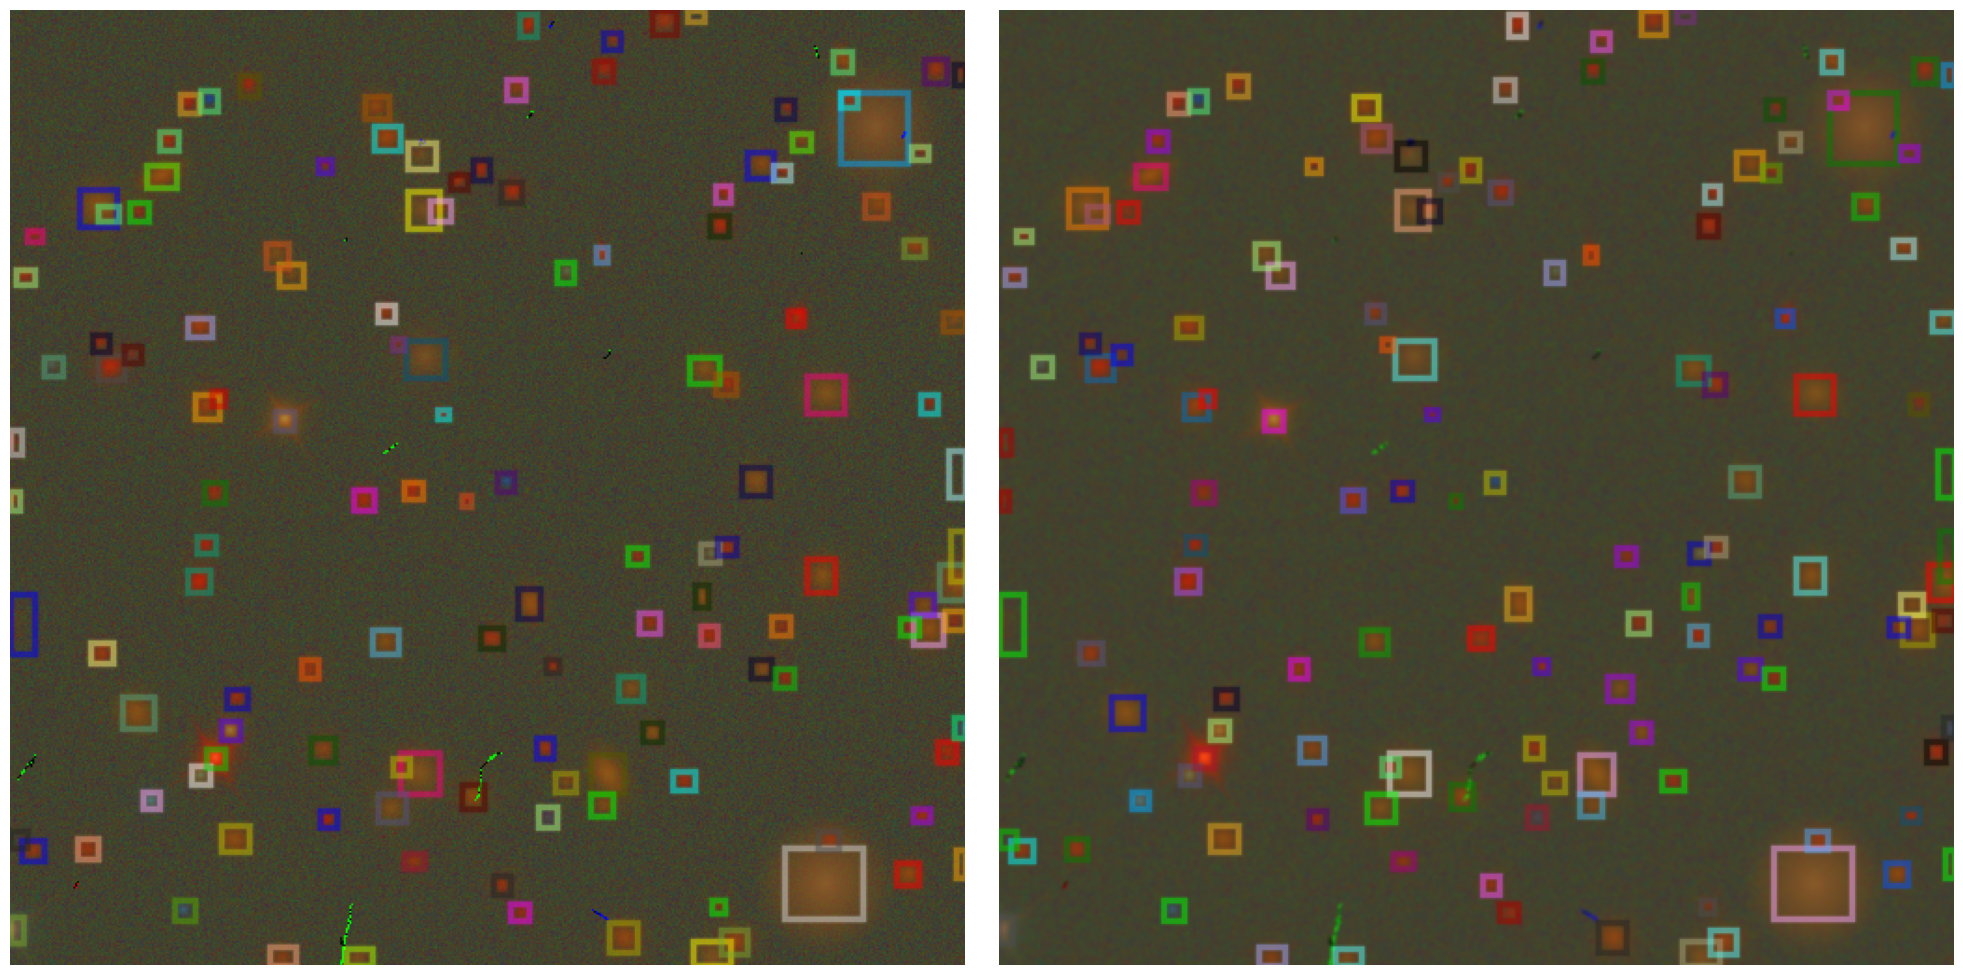

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10*2, 10))

#dictionary = iter(dataset_dicts['test'])
#d = next(dictionary)

d=random.sample(dataset_dicts['test'],1)[0]


img = read_image(d["file_name"], normalize="lupton", stretch=5, Q=10, ceil_percentile=99.99,dtype=np.uint8)
#img = rescale_image(d["file_name"], normalize="zscore", stretch=5, Q=10, ceil_percentile=99.9,dtype=np.int16)

visualizer = Visualizer(img, metadata=astro_metadata, scale=1)
# Get the ground truth boxes
gt_boxes = np.array([a['bbox'] for a in d['annotations']])
# Convert to the mode visualizer expects
gt_boxes = BoxMode.convert(gt_boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
out = visualizer.overlay_instances(boxes=gt_boxes)
axs[0].imshow(out.get_image())
axs[0].axis('off')

aug_d = train_mapper(d)
img_aug = aug_d["image_shaped"]
visualizer = Visualizer(img_aug, metadata=astro_metadata, scale=1)
# Convert to the mode visualizer expects
out = visualizer.overlay_instances(boxes=aug_d['instances'].gt_boxes)
axs[1].imshow(out.get_image())
axs[1].axis('off')
fig.tight_layout()
fig.show()

In [18]:
img_aug.shape

(256, 256, 3)

(-0.5, 511.5, 511.5, -0.5)

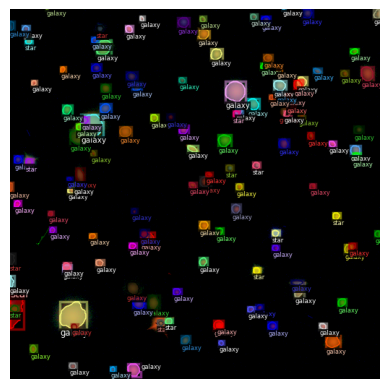

In [240]:
img = read_image(d["file_name"], normalize="zscore", stretch=5, Q=10, ceil_percentile=99.5,dtype=np.uint8)
#img = rescale_image(d["file_name"], normalize="zscore", stretch=5, Q=10, ceil_percentile=99.9,dtype=np.int16)

visualizer = Visualizer(img, metadata=astro_metadata, scale=1)
# Get the ground truth boxes
gt_boxes = np.array([a['bbox'] for a in d['annotations']])
# Convert to the mode visualizer expects
gt_boxes = BoxMode.convert(gt_boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
out = visualizer.draw_dataset_dict(d)
plt.imshow(out.get_image())
plt.axis('off')

### Prepare For Training

In [14]:
import detectron2.utils.comm as comm
from detectron2.utils.events import EventStorage, get_event_storage
from detectron2.utils.logger import _log_api_usage
from detectron2.utils.events import CommonMetricPrinter, JSONWriter, TensorboardXWriter
from typing import List, Mapping, Optional
from detectron2.engine import SimpleTrainer
from detectron2.engine import HookBase
from detectron2.engine.hooks import LRScheduler
from detectron2.solver import build_lr_scheduler, build_optimizer
from fvcore.common.param_scheduler import ParamScheduler
from detectron2.utils.logger import log_every_n_seconds
import datetime
import logging

In [15]:
class HelloHook(HookBase):
    def after_step(self):
        if self.trainer.iter % 2 == 0:
            print(f"Hello at iteration {self.trainer.iter}!")
            
            
class CustomLRScheduler(HookBase):
    """
    A hook which executes a torch builtin LR scheduler and summarizes the LR.
    It is executed after every iteration.
    """

    def __init__(self, optimizer=None, scheduler=None):
        """
        Args:
            optimizer (torch.optim.Optimizer):
            scheduler (torch.optim.LRScheduler or fvcore.common.param_scheduler.ParamScheduler):
                if a :class:`ParamScheduler` object, it defines the multiplier over the base LR
                in the optimizer.

        If any argument is not given, will try to obtain it from the trainer.
        """
        self._optimizer = optimizer
        self._scheduler = scheduler


    def before_train(self):
        self._optimizer = self._optimizer or self.trainer.optimizer
        if isinstance(self.scheduler, ParamScheduler):
            self._scheduler = LRMultiplier(
                self._optimizer,
                self.scheduler,
                self.trainer.max_iter,
                last_iter=self.trainer.iter - 1,
            )
        self._best_param_group_id = LRScheduler.get_best_param_group_id(self._optimizer)


    @staticmethod
    def get_best_param_group_id(optimizer):
        # NOTE: some heuristics on what LR to summarize
        # summarize the param group with most parameters
        largest_group = max(len(g["params"]) for g in optimizer.param_groups)

        if largest_group == 1:
            # If all groups have one parameter,
            # then find the most common initial LR, and use it for summary
            lr_count = Counter([g["lr"] for g in optimizer.param_groups])
            lr = lr_count.most_common()[0][0]
            for i, g in enumerate(optimizer.param_groups):
                if g["lr"] == lr:
                    return i
        else:
            for i, g in enumerate(optimizer.param_groups):
                if len(g["params"]) == largest_group:
                    return i


    def after_step(self):
        lr = self._optimizer.param_groups[self._best_param_group_id]["lr"]
        self.trainer.storage.put_scalar("lr", lr, smoothing_hint=False)
        self.scheduler.step()


    @property
    def scheduler(self):
        return self._scheduler or self.trainer.scheduler

    def state_dict(self):
        if isinstance(self.scheduler, _LRScheduler):
            return self.scheduler.state_dict()
        return {}


    def load_state_dict(self, state_dict):
        if isinstance(self.scheduler, _LRScheduler):
            logger = logging.getLogger(__name__)
            logger.info("Loading scheduler from state_dict ...")
            self.scheduler.load_state_dict(state_dict)
            
            
            
            
class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        self.trainer.add_val_loss(mean_loss)
        self.trainer.valloss=mean_loss

        comm.synchronize()
        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)


In [16]:

class CustomTrainer(DefaultTrainer):
    """Custom trainer that prints duration of each step of SimpleTrainer"""

    def __init__(self, model, data_loader, optimizer, cfg):
        super().__init__(cfg)
        # Assume these objects must be constructed in this order.
        model = self.build_model(cfg)
        optimizer = self.build_optimizer(cfg, model)
        data_loader = self.build_train_loader(cfg)

        self._trainer = AstroTrainer2(model, data_loader, optimizer, cfg)

class AstroTrainer2(SimpleTrainer):
    def __init__(self, model, data_loader, optimizer, cfg):
        super().__init__(model, data_loader, optimizer)
        #super().__init__(model, data_loader, optimizer)

        # Borrowed from DefaultTrainer constructor
        # see https://detectron2.readthedocs.io/en/latest/_modules/detectron2/engine/defaults.html#DefaultTrainer
        self.checkpointer = checkpointer.DetectionCheckpointer(
            # Assume you want to save checkpoints together with logs/statistics
            model,
            cfg.OUTPUT_DIR
        )
        # load weights
        self.checkpointer.load(cfg.MODEL.WEIGHTS)
        
        # record loss over iteration 
        self.lossList = []
        self.vallossList = []

        self.period = 20
        self.iterCount = 0
        
        self.scheduler = self.build_lr_scheduler(cfg, optimizer)
    
        self.valloss=0
    
    #Note: print out loss over p iterations
    def set_period(self,p):
        self.period = p

    
        
    # Copied directly from SimpleTrainer, add in custom manipulation with the loss
    # see https://detectron2.readthedocs.io/en/latest/_modules/detectron2/engine/train_loop.html#SimpleTrainer
    def run_step(self):
        self.iterCount = self.iterCount + 1
        assert self.model.training, "[SimpleTrainer] model was changed to eval mode!"
        start = time.perf_counter()
        data_time = time.perf_counter() - start
        data = next(self._data_loader_iter)
        # Note: in training mode, model() returns loss
        loss_dict = self.model(data)
        #print('Loss dict',loss_dict)
        if isinstance(loss_dict, torch.Tensor):
            losses = loss_dict
            loss_dict = {"total_loss": loss_dict}
        else:
            losses = sum(loss_dict.values())
        self.optimizer.zero_grad()
        losses.backward()
        
        
        self._write_metrics(loss_dict,data_time)

        self.optimizer.step()
        
        
        
        self.lossList.append(losses.cpu().detach().numpy())
        if self.iterCount % self.period == 0 and comm.is_main_process():
            print("Iteration: ", self.iterCount, " time: ", data_time," loss: ",losses, "val loss: ",self.valloss, "lr: ", self.scheduler.get_lr())
        
    @classmethod
    def build_lr_scheduler(cls, cfg, optimizer):
        """
        It now calls :func:`detectron2.solver.build_lr_scheduler`.
        Overwrite it if you'd like a different scheduler.
        """
        return build_lr_scheduler(cfg, optimizer)
    
    
    def add_val_loss(self,val_loss):
        """
        It now calls :func:`detectron2.solver.build_lr_scheduler`.
        Overwrite it if you'd like a different scheduler.
        """
        self.vallossList.append(val_loss)



In [20]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")) # Get model structure
print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 4
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('coco_2017_val',)
  TRAIN: ('coco_2017_train',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURES: ['res2', 

In [13]:
#self.scheduler = self.build_lr_scheduler(cfg, optimizer)

In [14]:
!nvidia-smi

Wed Jan 11 12:35:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000035:03:00.0 Off |                    0 |
| N/A   37C    P0    36W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
# Training logic:

# To replicate 2019 methodology, need to 
# 1) run intially with backbone frozen (freeze_at=4) for 15 epochs
# 2) unfreeze and run for [25,35,50] epochs with lr decaying by 0.1x each time




In [19]:
cfg.DATASETS.TRAIN

'astro_test'

In [16]:

# Step 1)

init_coco_weights = True # Start training from MS COCO weights

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")) # Get model structure
cfg.DATASETS.TRAIN = ("astro_test") # Register Metadata
cfg.DATASETS.TEST = ("astro_val") # Config calls this TEST, but it should be the val dataset
cfg.TEST.EVAL_PERIOD = 40
cfg.DATALOADER.NUM_WORKERS = 1
if init_coco_weights:
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # Initialize from MS COCO
else:
    cfg.MODEL.WEIGHTS = os.path.join(output_dir, 'model_temp.pth')  # Initialize from a local weights
cfg.SOLVER.IMS_PER_BATCH = 4  # this is images per iteration. 1 epoch is len(images)/(ims_per_batch iterations*num_gpus)
cfg.SOLVER.BASE_LR = 0.001    
cfg.SOLVER.STEPS = []         # do not decay learning rate for retraining
cfg.SOLVER.MAX_ITER = 200     # for DefaultTrainer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 250   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.PIXEL_MEAN = [-200,-200,-200]

cfg.MODEL.BACKBONE.FREEZE_AT = 4   # Initial re-training of the head layers (i.e. freeze the backbone)

cfg.MODEL.RPN.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[8, 16, 32, 64, 128]]
cfg.INPUT.MIN_SIZE_TRAIN = 512
cfg.INPUT.MAX_SIZE_TRAIN = 512

cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True
# Type of gradient clipping, currently 2 values are supported:
# - "value": the absolute values of elements of each gradients are clipped
# - "norm": the norm of the gradient for each parameter is clipped thus
#   affecting all elements in the parameter
cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE = "norm"
# Maximum absolute value used for clipping gradients
# Floating point number p for L-p norm to be used with the "norm"
# gradient clipping type; for L-inf, please specify .inf
cfg.SOLVER.CLIP_GRADIENTS.NORM_TYPE = 5.0

cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"
cfg.SOLVER.WARMUP_ITERS = 0

cfg.OUTPUT_DIR = output_dir
cfg.TEST.DETECTIONS_PER_IMAGE = 1000

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
model = modeler.build_model(cfg)
optimizer = solver.build_optimizer(cfg, model)
print(type(optimizer))

RuntimeError: No CUDA GPUs are available

In [24]:
loader = data.build_detection_train_loader(cfg, mapper=train_mapper)


[01/11 12:38:05 d2.data.build]: Removed 0 images with no usable annotations. 250 images left.
[01/11 12:38:05 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    star    | 3356         |   galaxy   | 30750        |
|            |              |            |              |
|   total    | 34106        |            |              |
[01/11 12:38:05 d2.data.build]: Using training sampler TrainingSampler
[01/11 12:38:05 d2.data.common]: Serializing 250 elements to byte tensors and concatenating them all ...
[01/11 12:38:05 d2.data.common]: Serialized dataset takes 4.07 MiB


In [27]:
test_loader = data.build_detection_test_loader(cfg,cfg.DATASETS.TEST,mapper=test_mapper)

[01/11 12:40:23 d2.data.common]: Serializing 250 elements to byte tensors and concatenating them all ...
[01/11 12:40:23 d2.data.common]: Serialized dataset takes 4.07 MiB


In [29]:
#tl=len(dataset_dicts['test'])
tl=1000
e1=int(tl/cfg.SOLVER.IMS_PER_BATCH*15)
e2=int(tl/cfg.SOLVER.IMS_PER_BATCH*10)
e3=int(tl/cfg.SOLVER.IMS_PER_BATCH*20)
efinal=int(tl/cfg.SOLVER.IMS_PER_BATCH*35)

print(e1/2,e2/2,e3/2,efinal/2)

1875.0 1250.0 2500.0 4375.0


In [30]:
#dataloader = build_detection_train_loader(cfg, mapper=train_mapper)

In [31]:
# Hack if you get SSL certificate error 
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [55]:
detectron2.__path__

['/home/g4merz/.local/lib/python3.9/site-packages/detectron2']

In [ ]:
print(trainer.scheduler.get_lr())
print(trainer.scheduler.state_dict())
#print(trainer.scheduler.last_epoch,trainer.scheduler._max_iter)
print(trainer.scheduler._multiplier(10 / trainer.scheduler._max_iter))

In [50]:
valperiod=50
saveHook = toolkit.SaveHook()
helloHook = HelloHook()
schedulerHook = CustomLRScheduler(optimizer=optimizer)
lossHook = LossEvalHook(valperiod, model, test_loader)

saveHook.set_output_name("test_zscore_notebook")
hookList = [lossHook,schedulerHook,saveHook]

#trainer = toolkit.AstroTrainer(model, loader, optimizer, cfg)
trainer = AstroTrainer2(model, loader, optimizer, cfg)
trainer.register_hooks(hookList)

Skip loading parameter 'proposal_generator.rpn_head.objectness_logits.weight' to the model due to incompatible shapes: (3, 256, 1, 1) in the checkpoint but (15, 256, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.objectness_logits.bias' to the model due to incompatible shapes: (3,) in the checkpoint but (15,) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.anchor_deltas.weight' to the model due to incompatible shapes: (12, 256, 1, 1) in the checkpoint but (60, 256, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.anchor_deltas.bias' to the model due to incompatible shapes: (12,) in the checkpoint but (60,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible

In [ ]:
t0 = time.time()
period=10
trainer.set_period(period) # print loss every n iterations
trainer.train(0,150)
print('time ', time.time()-t0)

[01/11 12:48:20 d2.engine.train_loop]: Starting training from iteration 0
Iteration:  10  time:  1.9604340195655823e-07  loss:  tensor(1.9278, device='cuda:0', grad_fn=<AddBackward0>) val loss:  0 lr:  [0.001]
Iteration:  20  time:  1.8207356333732605e-07  loss:  tensor(2.6317, device='cuda:0', grad_fn=<AddBackward0>) val loss:  0 lr:  [0.001]
Iteration:  30  time:  2.193264663219452e-07  loss:  tensor(1.9671, device='cuda:0', grad_fn=<AddBackward0>) val loss:  0 lr:  [0.001]
Iteration:  40  time:  2.2677704691886902e-07  loss:  tensor(1.8693, device='cuda:0', grad_fn=<AddBackward0>) val loss:  0 lr:  [0.001]
Iteration:  50  time:  2.5192275643348694e-07  loss:  tensor(1.9874, device='cuda:0', grad_fn=<AddBackward0>) val loss:  0 lr:  [0.001]
[01/11 12:48:46 detectron2]: Loss on Validation  done 11/250. 0.0000 s / img. ETA=0:00:15
[01/11 12:48:51 detectron2]: Loss on Validation  done 77/250. 0.0000 s / img. ETA=0:00:12
[01/11 12:48:56 detectron2]: Loss on Validation  done 143/250. 0.00

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffdd8c7d310>
Traceback (most recent call last):
  File "/home/g4merz/.conda/envs/astrodetnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/g4merz/.conda/envs/astrodetnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/g4merz/.conda/envs/astrodetnv/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffdd8c7d310>
Traceback (most recent call last):
  File "/home/g4merz/.conda/envs/astrodetnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/g4merz/.conda/envs/astrodetnv/lib/p

Iteration:  60  time:  1.9418075680732727e-07  loss:  tensor(1.9629, device='cuda:0', grad_fn=<AddBackward0>) val loss:  2.0832843526005744 lr:  [0.001]
Iteration:  70  time:  2.630986273288727e-07  loss:  tensor(1.9992, device='cuda:0', grad_fn=<AddBackward0>) val loss:  2.0832843526005744 lr:  [0.001]
Iteration:  80  time:  1.802109181880951e-07  loss:  tensor(1.9866, device='cuda:0', grad_fn=<AddBackward0>) val loss:  2.0832843526005744 lr:  [0.001]


In [102]:
print(trainer.scheduler)

In [131]:
def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(output_dir + 'metrics.json')

In [134]:
#/home/shared/hsc/decam/test/metrics.json
output_dir + 'metrics.json'

'/home/shared/hsc/decam/test/metrics.json'

In [1]:
1000/4/2

125.0

In [70]:
# Step 2)

cfg.MODEL.BACKBONE.FREEZE_AT = 0  # unfreeze all backbone layers  
cfg.SOLVER.BASE_LR = 0.0001   
#cfg.SOLVER.STEPS = [e2,e3]        # decay learning rate
cfg.SOLVER.STEPS = [500,1000]        # decay learning rate

cfg.SOLVER.MAX_ITER = efinal          # for DefaultTrainer
cfg.MODEL.WEIGHTS = os.path.join(output_dir, 'test_zscore_notebook.pth')  # Initialize from a local weights

model = modeler.build_model(cfg)
optimizer = solver.build_optimizer(cfg, model)
loader = data.build_detection_train_loader(cfg, mapper=train_mapper)


[01/03 13:08:56 d2.data.build]: Removed 0 images with no usable annotations. 250 images left.
[01/03 13:08:56 d2.data.build]: Using training sampler TrainingSampler
[01/03 13:08:56 d2.data.common]: Serializing 250 elements to byte tensors and concatenating them all ...
[01/03 13:08:57 d2.data.common]: Serialized dataset takes 4.07 MiB


In [71]:
trainer = toolkit.AstroTrainer(model, loader, optimizer, cfg)
trainer.register_hooks(hookList)
trainer.set_period(20) # print loss every n iterations
trainer.train(0, 400)

[01/03 13:09:18 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                         | Shapes                                          |
|:------------------------------------------------|:--------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.res2.0.conv1.*                         | backbone.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}     | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.res2.0.conv2.*                         | backbone.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}     | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.res2.0.conv3.*                         | backbone.res2.0.conv3.{norm.bias,norm.running_mean,norm.running_var,norm.weig

[01/03 13:09:18 d2.engine.train_loop]: Starting training from iteration 0
Iteration:  20  time:  3.941822797060013e-07  loss:  tensor(1.8597, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  40  time:  3.259629011154175e-07  loss:  tensor(1.6943, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  60  time:  2.621673047542572e-07  loss:  tensor(1.8961, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  80  time:  2.7497299015522003e-07  loss:  tensor(1.8446, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  100  time:  2.2794120013713837e-07  loss:  tensor(1.8233, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  120  time:  3.57162207365036e-07  loss:  tensor(1.8347, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  140  time:  2.50060111284256e-07  loss:  tensor(1.8489, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  160  time:  3.869645297527313e-07  loss:  tensor(1.7906, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  180  time:  3.1315721571445465e-07  lo

In [39]:
output_dir = '/home/shared/hsc/decam/models/'
output_name='baseline_R101'
print(os.path.join(output_dir, output_name+'.pth'))


/home/shared/hsc/decam/models/baseline_R101.pth


### Plot The Loss

In [63]:
iters = np.arange(len(trainer.vallossList))*period
iters

array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180])

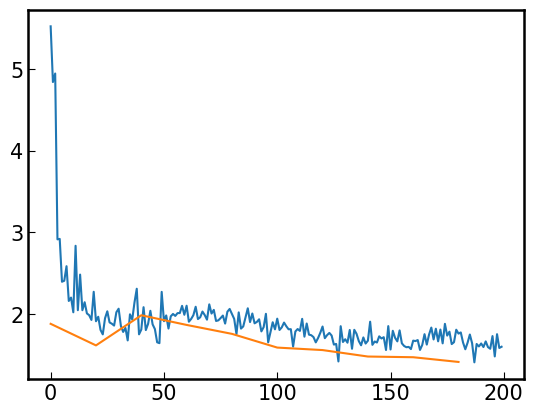

In [64]:
#l1 = trainer.lossList
iters = np.arange(len(trainer.vallossList))*period

plt.plot(trainer.lossList)
plt.plot(iters,trainer.vallossList)

In [397]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output --host localhost

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 1389625), started 0:05:55 ago. (Use '!kill 1389625' to kill it.)

In [38]:
losses = np.load('/home/shared/hsc/decam/models/int16/R101fpn_sat99.99_zscore_losses.npy')
val_losses = np.load('/home/shared/hsc/decam/models/int16/R101fpn_sat99.99_zscore_val_losses.npy')

vperiod = np.ceil(len(losses)/len(val_losses))
iters = np.arange(len(val_losses))*vperiod
print(vperiod)

250.0


In [39]:
len(losses)


12500

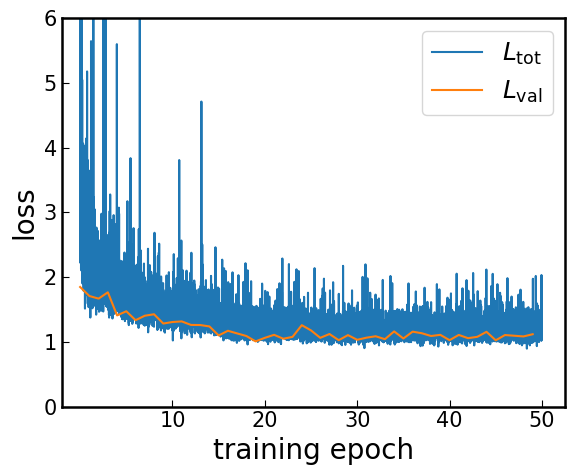

In [40]:
epochs = np.array([1000/4*10,1000/4*20,1000/4*30,1000/4*40,1000/4*50])
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.set_xticks(epochs)
ax.set_xticklabels(['10','20','30','40','50'])
ax.set_xlim(-500,len(losses)*1.05)
ax.set_ylim(0,6)

ax.plot(losses, label=r'$L_{\rm{tot}}$')
ax.plot(iters,val_losses, label=r'$L_{\rm{val}}$')

ax.legend(loc='upper right')
ax.set_xlabel('training epoch', fontsize=20)
ax.set_ylabel('loss', fontsize=20)
fig.tight_layout()

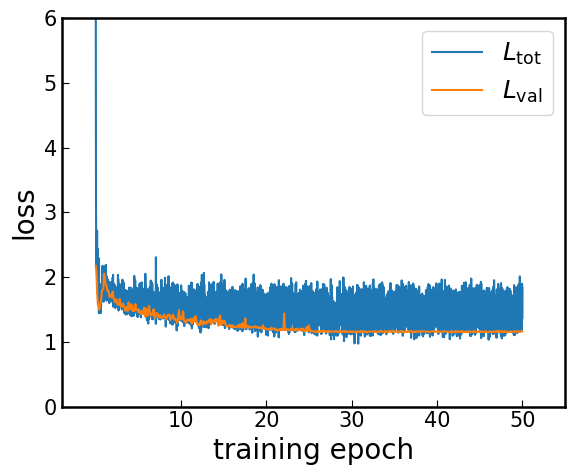

In [21]:
epochs = np.array([1000/4*10,1000/4*20,1000/4*30,1000/4*40,1000/4*50])
losses = np.load('/home/shared/hsc/decam/models/newbaseline_R101_losses.npy')
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.set_xticks(epochs/2)
ax.set_xticklabels(['10','20','30','40','50'])
ax.set_xlim(-500,6875)
ax.set_ylim(0,6)

ax.plot(losses, label=r'$L_{\rm{tot}}$')
ax.plot(iters,val_losses, label=r'$L_{\rm{val}}$')

ax.legend(loc='upper right')
ax.set_xlabel('training epoch', fontsize=20)
ax.set_ylabel('loss', fontsize=20)
fig.tight_layout()

### Inference

In [89]:
import importlib
importlib.reload(toolkit)
from astrodet import astrodet as toolkit
toolkit.AstroPredictor
output_dir = '/home/shared/hsc/decam/models/int16/'


In [90]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")) # Get model structure
#cfg.DATASETS.TRAIN = ("astro_train") # Register Metadata
cfg.DATASETS.TEST = ("astro_val") # Config calls this TEST, but it should be the val dataset
cfg.TEST.EVAL_PERIOD = 40
cfg.DATALOADER.NUM_WORKERS = 1
cfg.SOLVER.IMS_PER_BATCH = 4  # this is images per iteration. 1 epoch is len(images)/(ims_per_batch iterations*num_gpus)
cfg.SOLVER.BASE_LR = 0.001    
cfg.SOLVER.STEPS = []         # do not decay learning rate for retraining
cfg.SOLVER.MAX_ITER = 100     # for DefaultTrainer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 250   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.OUTPUT_DIR = output_dir
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
cfg.MODEL.PIXEL_MEAN= [-200,-200,-200]
cfg.INPUT.MIN_SIZE_TEST = 512
cfg.INPUT.MAX_SIZE_TEST = 512

cfg.MODEL.RPN.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[8, 16, 32, 64, 128]]

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "oldbaseline.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
#predictor = DefaultPredictor(cfg)
predictor = toolkit.AstroPredictor(cfg)

[01/17 14:34:00 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

total instances: 137
detected instances: 114

total instances: 135
detected instances: 98

total instances: 169
detected instances: 127



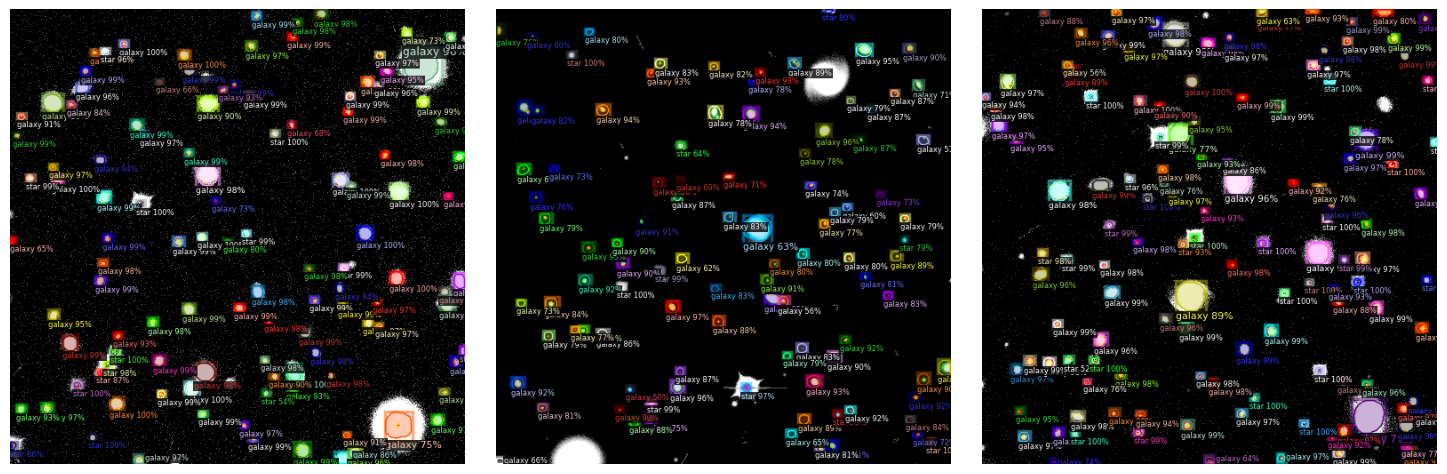

In [93]:
from detectron2.utils.visualizer import ColorMode

nsample = 3
fig, axs = plt.subplots(1, nsample, figsize=(5*nsample, 5))

for i, d in enumerate(random.sample(dataset_dicts['test'], nsample)):
    #img = read_image(d["file_name"], normalize="zscore", stretch=5, Q=1, ceil_percentile=99.99, dtype=np.int16)
    img = rescale_image(d["file_name"], normalize='zscore', dtype=np.int16, ceil_percentile=99.995)

    outputs = predictor(img)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    
    print('total instances:', len(d['annotations']))
    print('detected instances:', len(outputs['instances'].pred_boxes))
    print('')
    
    v = Visualizer(img,
                   metadata=astro_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axs[i].imshow(out.get_image())
    axs[i].axis('off')
    fig.tight_layout()
    fig.show()

### Evaluate

In [94]:
def test_mapper(dataset_dict, **read_image_args):

    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below

    #image = read_image(dataset_dict["file_name"], normalize="zscore", stretch=5, Q=1, ceil_percentile=99.99, dtype=np.uint8)
    image = rescale_image(dataset_dict["file_name"], normalize='zscore', dtype=np.int16, ceil_percentile=99.995)

    augs = T.AugmentationList([
        #T.RandomRotation([-90, 90, 180], sample_style='choice'),
        #T.RandomFlip(prob=0.5),
        #T.Resize((512,512))
    ])
    # Data Augmentation
    auginput = T.AugInput(image)
    # Transformations to model shapes
    transform = augs(auginput)
    image = torch.from_numpy(auginput.image.copy().transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]
    return {
       # create the format that the model expects
        "image": image,
        "image_shaped": auginput.image,
        "height": 512,
        "width": 512,
        "image_id": dataset_dict["image_id"],
        "instances": utils.annotations_to_instances(annos, image.shape[1:]),
        "annotations": annos
    }

In [95]:
# All of the astro_train_coco... stuff gets generated here...
# only keep last_checkpoint and model_temp.pth files really.

In [96]:
from detectron2.evaluation import inference_on_dataset
from detectron2.data import build_detection_test_loader

# NOTE: New version has max_dets_per_image argument in default COCOEvaluator
evaluator = toolkit.COCOEvaluatorRecall("astro_val", use_fast_impl=True, output_dir=cfg.OUTPUT_DIR)

# First run with train_mapper to generate .json files consistent with training format
# Then run with test_mapper to get AP scores (doesn't work with augmentation mapper)
train_loader = build_detection_test_loader(dataset_dicts['val'], mapper=train_mapper)
test_loader = build_detection_test_loader(dataset_dicts['val'], mapper=test_mapper)

[01/17 14:34:37 d2.data.common]: Serializing 250 elements to byte tensors and concatenating them all ...
[01/17 14:34:37 d2.data.common]: Serialized dataset takes 4.06 MiB
[01/17 14:34:37 d2.data.common]: Serializing 250 elements to byte tensors and concatenating them all ...
[01/17 14:34:37 d2.data.common]: Serialized dataset takes 4.06 MiB


In [97]:
results = inference_on_dataset(predictor.model, test_loader, evaluator)

[01/17 14:34:41 d2.evaluation.evaluator]: Start inference on 250 batches
[01/17 14:34:43 d2.evaluation.evaluator]: Inference done 11/250. Dataloading: 0.0659 s/iter. Inference: 0.0534 s/iter. Eval: 0.0633 s/iter. Total: 0.1826 s/iter. ETA=0:00:43
[01/17 14:34:48 d2.evaluation.evaluator]: Inference done 35/250. Dataloading: 0.0890 s/iter. Inference: 0.0539 s/iter. Eval: 0.0647 s/iter. Total: 0.2078 s/iter. ETA=0:00:44
[01/17 14:34:53 d2.evaluation.evaluator]: Inference done 61/250. Dataloading: 0.0830 s/iter. Inference: 0.0540 s/iter. Eval: 0.0650 s/iter. Total: 0.2021 s/iter. ETA=0:00:38
[01/17 14:34:58 d2.evaluation.evaluator]: Inference done 87/250. Dataloading: 0.0809 s/iter. Inference: 0.0539 s/iter. Eval: 0.0645 s/iter. Total: 0.1993 s/iter. ETA=0:00:32
[01/17 14:35:03 d2.evaluation.evaluator]: Inference done 113/250. Dataloading: 0.0796 s/iter. Inference: 0.0538 s/iter. Eval: 0.0641 s/iter. Total: 0.1977 s/iter. ETA=0:00:27
[01/17 14:35:08 d2.evaluation.evaluator]: Inference done

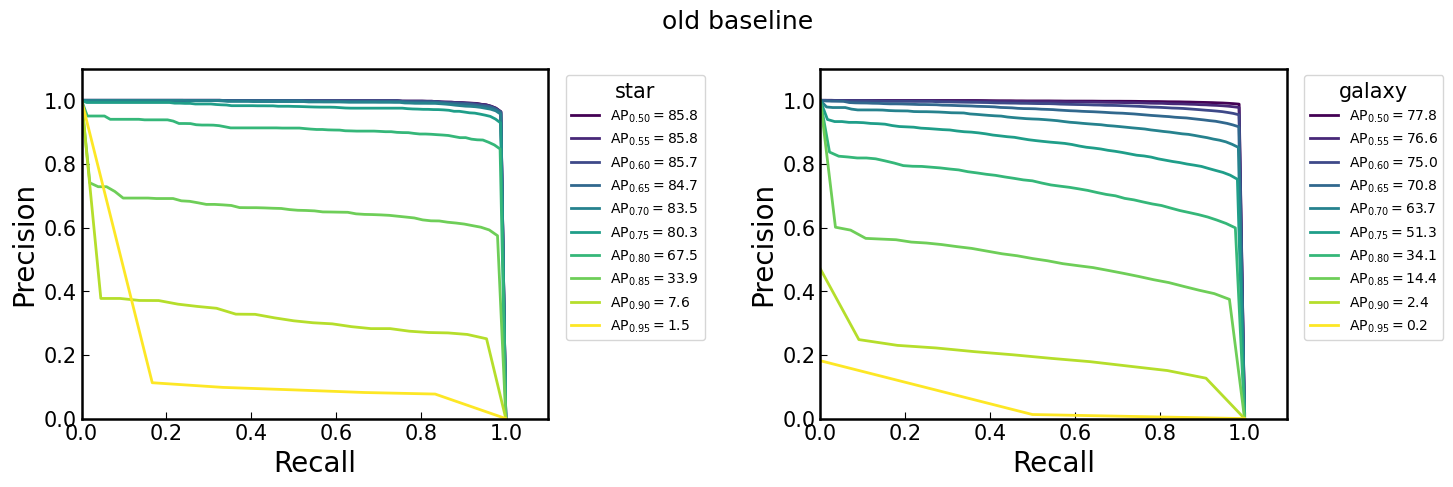

In [98]:
ap_type = 'bbox' # Which type of precision/recall to use? 'segm', or 'bbox'
cls_names = ['star', 'galaxy']

results_per_category = results[ap_type]['results_per_category']

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.flatten()

ious = np.linspace(0.50,0.95,10)
colors = plt.cm.viridis(np.linspace(0,1,len(ious)))

# Plot precision recall
for j, precision_class in enumerate(results_per_category):
    precision_shape = np.shape(precision_class)
    for i in range(precision_shape[0]):
        # precision has dims (iou, recall, cls, area range, max dets)
        # area range index 0: all area ranges
        # max dets index -1: typically 100 per image
        p_dat = precision_class[i, :, j, 0, -1]
        # Hide vanishing precisions
        mask = (p_dat > 0)
        # Only keep first occurance of 0 value in array
        mask[np.cumsum(~mask) == 1] = True
        p = p_dat[mask]
        # Recall points
        r = np.linspace(0, 1, len(p)) # Recall is always defined from 0 to 1 for these plots, I think
        dr = np.diff(np.linspace(0, 1, len(p_dat)))[0] # i think
        # Plot
        iou = np.around(ious[i], 2)
        AP = 100*np.sum(p*dr)
        axs[j].plot(r, p, label=r'${\rm{AP}}_{%.2f} = %.1f$' % (iou, AP), color=colors[i], lw=2) # use a viridis color scheme
        axs[j].set_xlabel('Recall', fontsize=20)
        axs[j].set_ylabel('Precision', fontsize=20)
        axs[j].set_xlim(0, 1.1)
        axs[j].set_ylim(0, 1.1)
        axs[j].legend(fontsize=10, title=f'{cls_names[j]}', bbox_to_anchor=(1.35, 1.0))
plt.suptitle('old baseline')

fig.tight_layout()

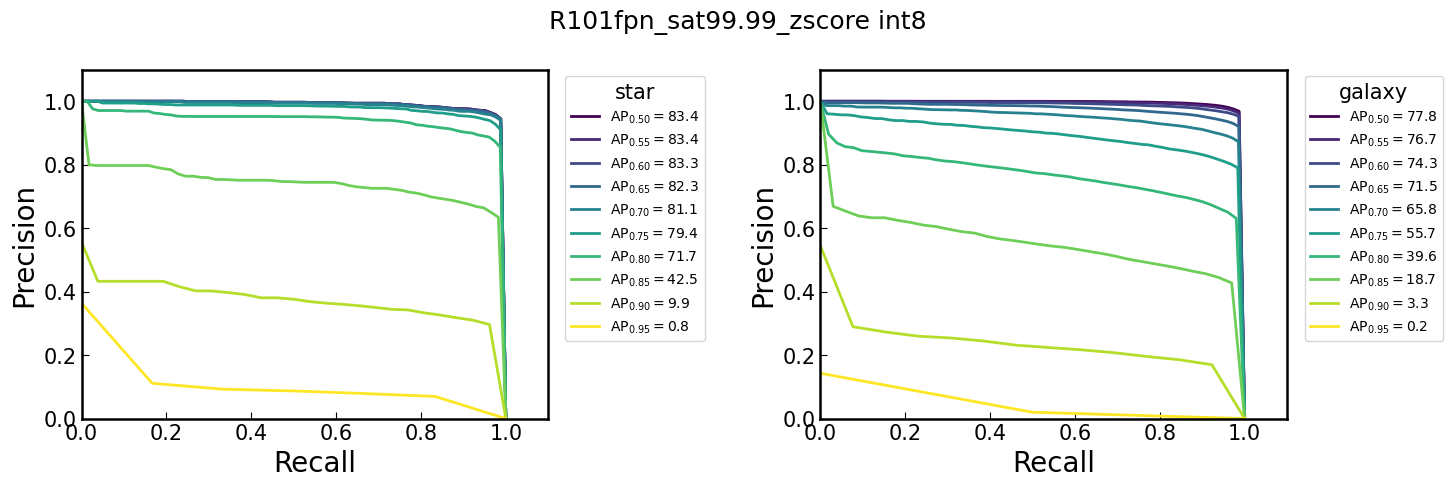

In [88]:
ap_type = 'bbox' # Which type of precision/recall to use? 'segm', or 'bbox'
cls_names = ['star', 'galaxy']

results_per_category = results[ap_type]['results_per_category']

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.flatten()

ious = np.linspace(0.50,0.95,10)
colors = plt.cm.viridis(np.linspace(0,1,len(ious)))

# Plot precision recall
for j, precision_class in enumerate(results_per_category):
    precision_shape = np.shape(precision_class)
    for i in range(precision_shape[0]):
        # precision has dims (iou, recall, cls, area range, max dets)
        # area range index 0: all area ranges
        # max dets index -1: typically 100 per image
        p_dat = precision_class[i, :, j, 0, -1]
        # Hide vanishing precisions
        mask = (p_dat > 0)
        # Only keep first occurance of 0 value in array
        mask[np.cumsum(~mask) == 1] = True
        p = p_dat[mask]
        # Recall points
        r = np.linspace(0, 1, len(p)) # Recall is always defined from 0 to 1 for these plots, I think
        dr = np.diff(np.linspace(0, 1, len(p_dat)))[0] # i think
        # Plot
        iou = np.around(ious[i], 2)
        AP = 100*np.sum(p*dr)
        axs[j].plot(r, p, label=r'${\rm{AP}}_{%.2f} = %.1f$' % (iou, AP), color=colors[i], lw=2) # use a viridis color scheme
        axs[j].set_xlabel('Recall', fontsize=20)
        axs[j].set_ylabel('Precision', fontsize=20)
        axs[j].set_xlim(0, 1.1)
        axs[j].set_ylim(0, 1.1)
        axs[j].legend(fontsize=10, title=f'{cls_names[j]}', bbox_to_anchor=(1.35, 1.0))
plt.suptitle('R101fpn_sat99.99_zscore int8')
        
fig.tight_layout()

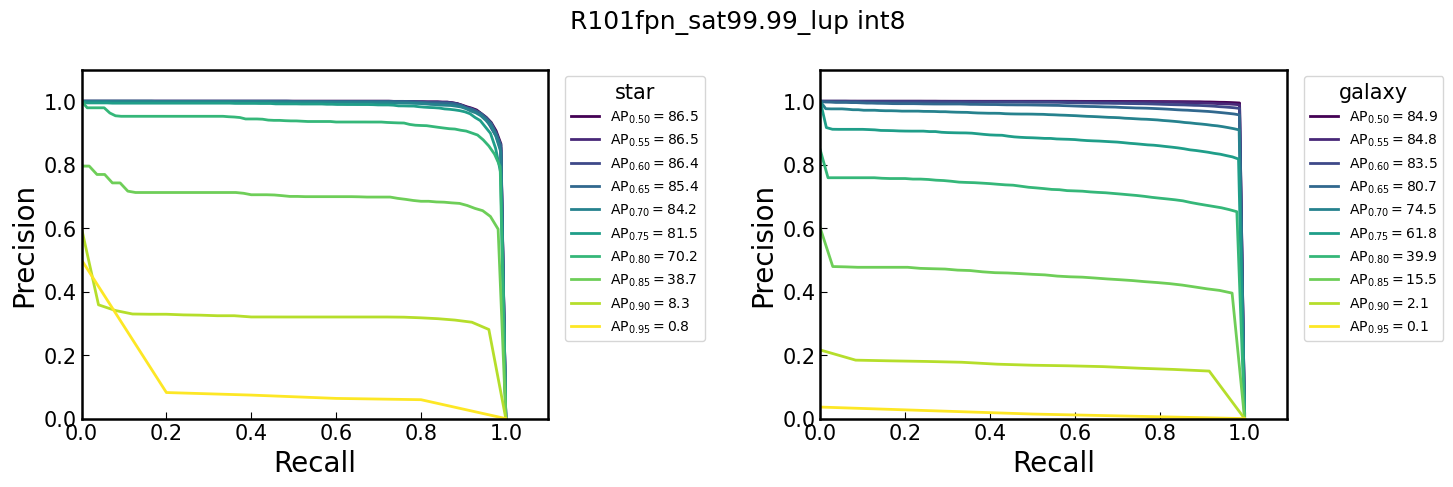

In [75]:
ap_type = 'bbox' # Which type of precision/recall to use? 'segm', or 'bbox'
cls_names = ['star', 'galaxy']

results_per_category = results[ap_type]['results_per_category']

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.flatten()

ious = np.linspace(0.50,0.95,10)
colors = plt.cm.viridis(np.linspace(0,1,len(ious)))

# Plot precision recall
for j, precision_class in enumerate(results_per_category):
    precision_shape = np.shape(precision_class)
    for i in range(precision_shape[0]):
        # precision has dims (iou, recall, cls, area range, max dets)
        # area range index 0: all area ranges
        # max dets index -1: typically 100 per image
        p_dat = precision_class[i, :, j, 0, -1]
        # Hide vanishing precisions
        mask = (p_dat > 0)
        # Only keep first occurance of 0 value in array
        mask[np.cumsum(~mask) == 1] = True
        p = p_dat[mask]
        # Recall points
        r = np.linspace(0, 1, len(p)) # Recall is always defined from 0 to 1 for these plots, I think
        dr = np.diff(np.linspace(0, 1, len(p_dat)))[0] # i think
        # Plot
        iou = np.around(ious[i], 2)
        AP = 100*np.sum(p*dr)
        axs[j].plot(r, p, label=r'${\rm{AP}}_{%.2f} = %.1f$' % (iou, AP), color=colors[i], lw=2) # use a viridis color scheme
        axs[j].set_xlabel('Recall', fontsize=20)
        axs[j].set_ylabel('Precision', fontsize=20)
        axs[j].set_xlim(0, 1.1)
        axs[j].set_ylim(0, 1.1)
        axs[j].legend(fontsize=10, title=f'{cls_names[j]}', bbox_to_anchor=(1.35, 1.0))
plt.suptitle('R101fpn_sat99.99_lup int8')
fig.tight_layout()
